In [280]:
# python modules
import os
import itertools

# some modules
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation
# netcdf
import netCDF4
# colormap
import cmocean

import IPython.display
from ipywidgets import interact, interactive, fixed
import seaborn as sns
sns.set()

%matplotlib inline

In [219]:
# dataset from http://volkov.oce.orst.edu/tides/global.html
ds = netCDF4.Dataset(
    os.path.expanduser('~/data/osu/DATA/h_tpxo7.2.nc')
)

In [221]:
# This variable gives the constituents
con_string = netCDF4.chartostring(ds.variables['con'][:])
constituents = [x.strip().upper().decode('ascii') for x in con_string]


In [222]:
lon = ds.variables['lon_z'][:]
lat = ds.variables['lat_z'][:]
island = ~ds.variables['hp'][:].any(axis=0)

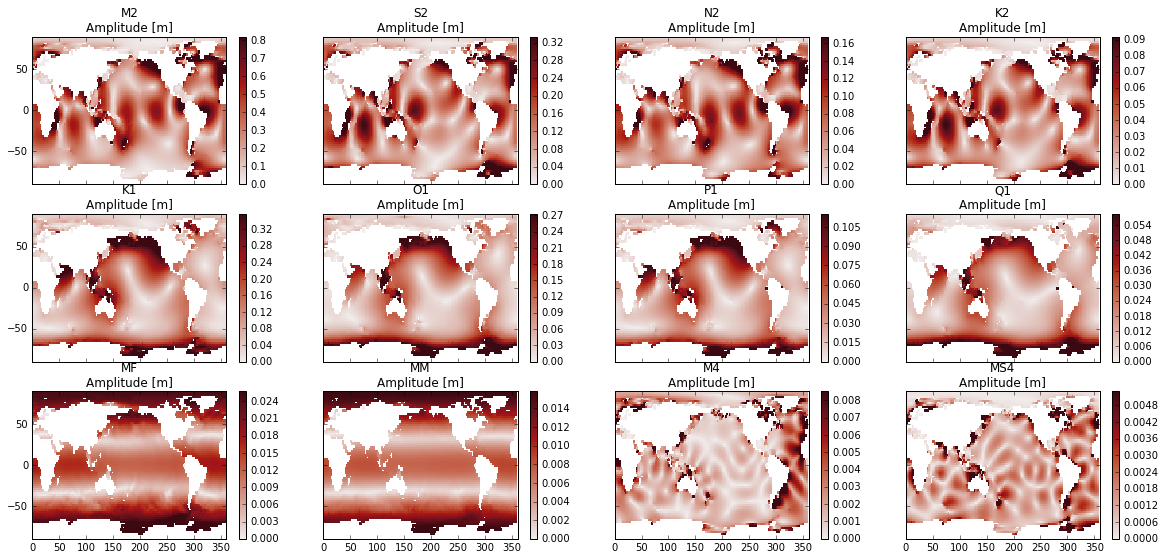

In [262]:
fig, axes = plt.subplots(3, ds.variables['ha'].shape[0]//3, figsize=(20,9), sharex=True, sharey=True)
for i, ax in enumerate(axes.flat):
    A = np.ma.masked_array(ds.variables['ha'][i,::10,::10], mask=island[::10, ::10])
    pc = ax.pcolormesh(
        lon[::10,::10],
        lat[::10,::10], 
        A, 
        vmin=0, 
        vmax=np.percentile(A.ravel(), 97.5), 
        cmap=cmocean.cm.waveheight
    )
    cb = plt.colorbar(pc, ax=ax)
    ax.set_title(constituents[i] + '\n' + 'Amplitude [m]')
    ax.set_xlim(0, 360)
    ax.set_ylim(-90, 90)    

In [286]:
husl = sns.husl_palette(30)
husl = matplotlib.colors.ListedColormap(husl)

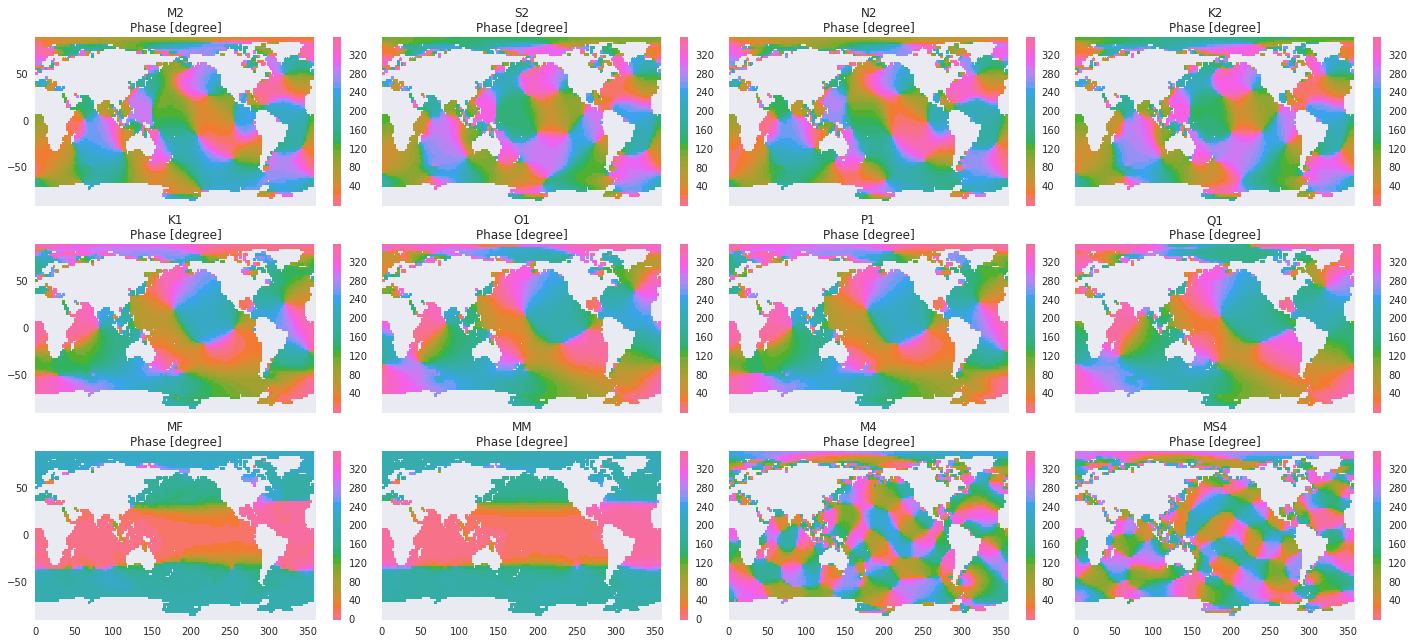

In [287]:
fig, axes = plt.subplots(3, ds.variables['hp'].shape[0]//3, figsize=(20, 9), sharex=True, sharey=True)
for i, ax in enumerate(axes.flat):
    phi = np.ma.masked_array(ds.variables['hp'][i,::10,::10], mask=island[::10,::10])
    pc = ax.pcolormesh(
        lon[::10,::10],
        lat[::10,::10], 
        phi, 
        cmap=husl
    )
    cb = plt.colorbar(pc, ax=ax)
    ax.set_title(constituents[i] + '\n' + 'Phase [degree]')
    ax.set_xlim(0, 360)
    ax.set_ylim(-90, 90)
    fig.tight_layout()

(-90, 90)

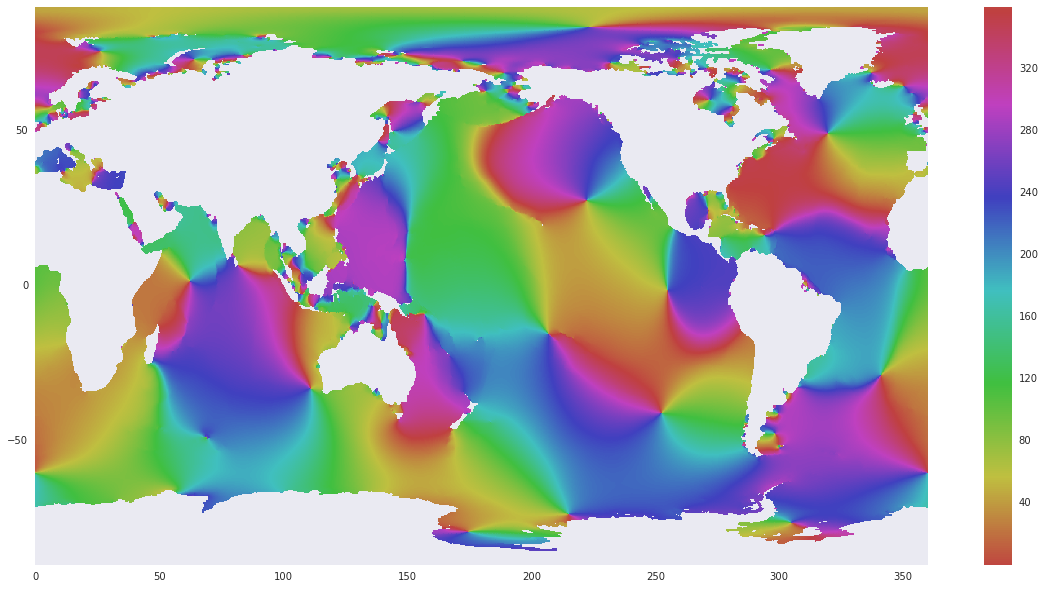

In [306]:
husl = sns.husl_palette(100, h=0.3, s=0.9, l=0.7)
hls = sns.hls_palette(255, l=0.5, s=0.5)
hls = matplotlib.colors.ListedColormap(hls)
husl = matplotlib.colors.ListedColormap(husl)
plt.figure(figsize=(20,10))
pc = plt.pcolormesh(
    lon,
    lat,
    np.ma.masked_array(ds.variables['hp'][0], mask=island), 
    cmap=hls
)
plt.colorbar()
plt.xlim(0, 360)
plt.ylim(-90, 90)



In [273]:
# in degrees/hour from IHO dataset

# semi diurnal 
speeds = {
    "M2": 28.984104,
    "S2": 30.0,
    "N2": 28.43973,
    "K2": 30.082138,
# diurnal    
    "K1": 15.041069,
    "O1": 13.943035,
    "P1": 14.958931,
    "Q1": 13.398661,

# long term
    "MF": 1.0980331,
    "MM": 0.5443747,
    
# short term    
    "M4": 57.96821,
    "MS4": 58.984104,
    "MN4": 57.423832
}
    


In [274]:
speed = np.asarray([speeds[constituent] for constituent in constituents])[:, np.newaxis, np.newaxis]

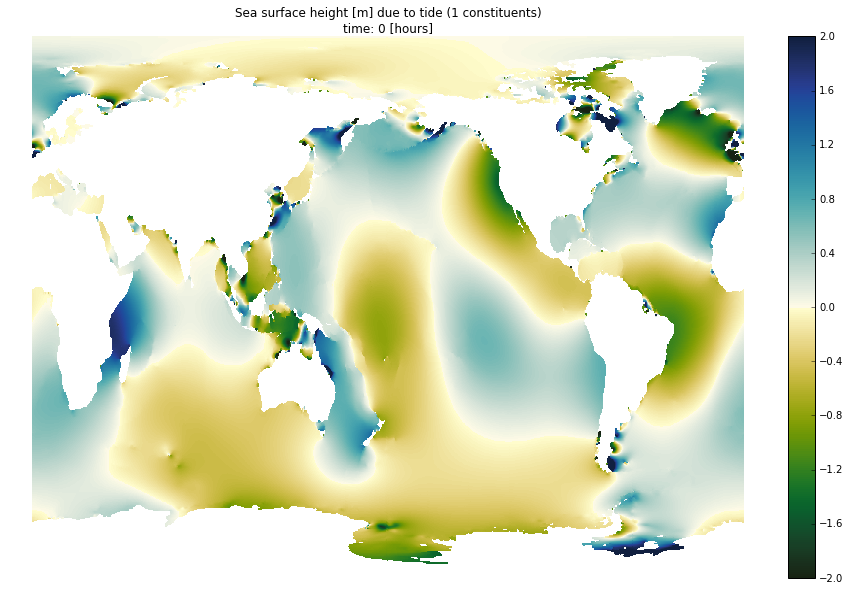

In [277]:
# amplitude
# phase 
A = ds.variables['ha'][:]
phi = ds.variables['hp']

# compute waterlevel (just harmonics)
eta0 = (A * np.cos(0 * np.deg2rad(speed) - np.deg2rad(phi))).sum(axis=0)

# create a default plot so we can replace the data
fig, ax = plt.subplots(figsize=(13, 8))
pc = plt.pcolormesh(
    lon,
    lat,
    np.ma.masked_array(eta0, mask=island),
    cmap=cmocean.cm.velocity_r,
    vmin=-2, 
    vmax=2
)
# it's on earth
plt.xlim(0, 360)
plt.ylim(-90, 90)
plt.axis('off')
plt.tight_layout()
plt.colorbar(pc, ax=ax)
plt.title('Sea surface height [m] due to tide (%s constituents)\ntime: %s [hours]' % (1, 0))

def plot(t, n_constituents=None):
    if n_constituents is None:
        n_constituents = speed.shape[0]
    parts = (A * np.cos(t * np.deg2rad(speed) - np.deg2rad(phi)))
    eta = np.ma.masked_array(
        parts[:n_constituents].sum(axis=0),
        mask=island
    )
    ax.set_title('Sea surface height [m] due to tide (%s constituents)\ntime: %s [hours]' % (n_constituents, t))
    pc.set_array(eta[:-1,:-1].ravel())
    
    


In [278]:
FFMpegWriter = matplotlib.animation.writers['ffmpeg']
metadata = dict(title='Movie Test', artist='Matplotlib',
                comment='Movie support!')
writer = FFMpegWriter(fps=24, metadata=metadata, bitrate=2000, extra_args=['-vcodec', 'libx264'])

t = 0
with writer.saving(fig, "writer_test.mp4", 100):
    for n_constituents in [1, speed.shape[0]]:
        for i in range(1000):
            plot(t=t, n_constituents=n_constituents)
            writer.grab_frame()
            t += 0.1
